In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Linear Regression

The most familar is the simple linear regression, aka a straight-line fit to the data.

$$y=ax+b$$
where $a$ is the slope and $b$ is the intercept.

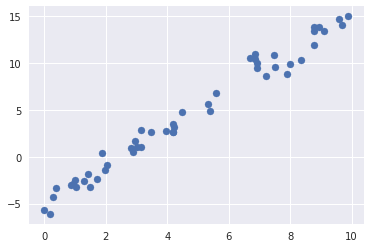

In [2]:
#created data with a slope of 2 and intercept of -5
#added random noise to the y values
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

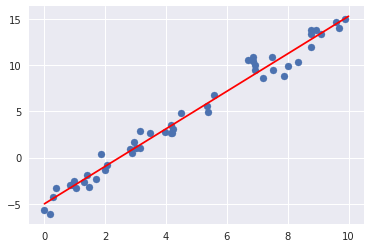

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit, c='r');

In [4]:
#lets look at the model's slope and intercept
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)
#pretty close!

Model slope:     2.02720881036
Model intercept: -4.99857708555


We can use the form of the linear equation to move beyond this and look at multidimensional linear models. These are of the form;

$$y = a_{0} + a_{1}x_{1} + a_{2}x_{2} + \dots + a_{k}x_{k}$$

Here instead of a line, the model is fiting a hyper-plane to points in higher dimensions.

It become very difficult to visualize high dimension and the regressions fit to it, but we still use the `LinearRegression` estimator to fit the data and return the intercept and coefficients for each feature.

In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5
[ 1.5 -2.   1. ]


### Adapting Linear Regression

We can adapt linear regression to nonlinear relationships by transforming the data according  to **basis functions**.

Here we take the multidimensional linear model;

$$y = a_{0} + a_{1}x_{1} + a_{2}x_{2} + \dots + a_{k}x_{k}$$

and build $x_{1},x_{2},\dots,x_{n}$ from our single-dimensional input $x$ by allowing $x_{n}=f_{n}(x)$ where $f_{n}()$ is a function that transforms our data.

So, if $f_{n}(x)=x_{n}$ the model is now a polynomial regression of the form;

$$y = a_{0} + a_{1}x + a_{2}x^{2} + \dots + a_{n}x^{n}$$

### Polynomail Basis Function

This function if actually built in Scikit-Learn. It transforms a one-dimensional array to a multi-dimensional array by taking the exponent of each value.

In [6]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.]])

In [7]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

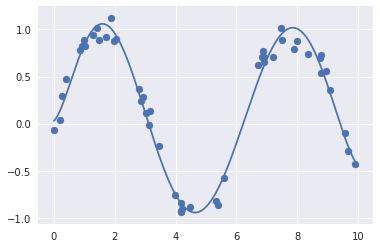

In [8]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

### Gaussian Basis Function

One useful patern is fit a model that is not a sum of polynomial bases, but a sum of Guassian bases. This basis function is not in Scikit-Learn, but can be written in Python fairly easily.

The Guassian basis function on two samples $x$ and $x'$, represented as feature vectors in some input space, is;

$$K(x,x') = exp(-\frac{\|x-x'\|^{2}}{2\sigma^{2}})$$

where $\|x-x'\|^{2}$ is the squared Euclidean distance between the two feature vectors. This can be easier to interpert if we let $\lambda=\frac{1}{2\sigma^{2}}$.

Then we have $K(x,x') = exp(-\lambda\|x-x'\|^{2})$ which for $\sigma=1$ is $K(x,x') = exp(-\frac{1}{2}\|x-x'\|^{2})$

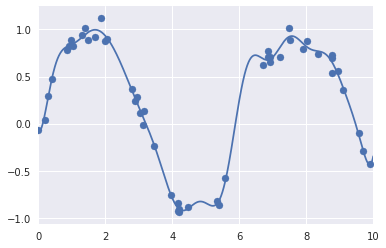

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

Basic functions make the model much more flexible, which can lead to over=fitting.

If we plot the coefficients for the bases with repsect to their locations we can see overfitting. When basis function overlap, the coefficients of adjacent basis functions blow up and cancel each other out.

To limit these spike, we can penalize large value of the model parameters. This penalty is known as **regularization** and there are several ways to do it.

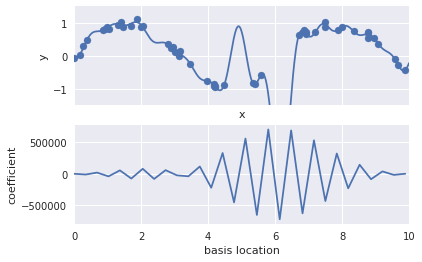

In [10]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

### Ridge Regression ($L_{2}$ Regularization)

The most common form of regularization is known as **ridge regression** or **$L_{2}$ regularization** and sometimes **Tikhonov regularization**.

This penalizes the sum of squares of the model coefficients;

$$P = \alpha \sum_{n=1}^{N}\theta^{2}_{n}$$

where $\alpha$ is a free parameter that controls the strength of the penalty.

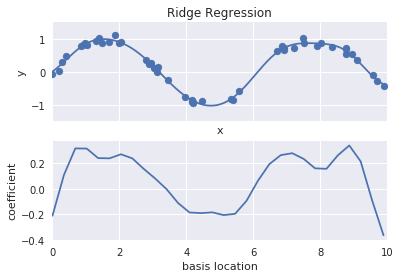

In [11]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

We can see $\alpha$ controlls the complexity of the resulting model. One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

### Lasso regression ($L_{1}$ regularization)

**Lasso regression** or **$L_{1}$ regularization** penalizes the sum of aboslute values of regression coefficients.

$$P=\alpha\sum_{n=1}^{N}|\theta_{n}|$$

The lasso regression favors *sparse models*, models where the coefficients are zero.

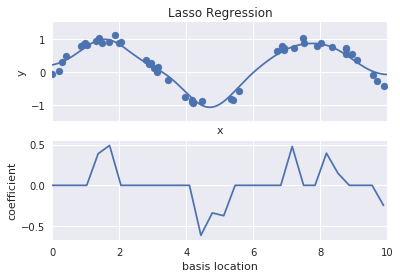

In [12]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.01))
basis_plot(model, title='Lasso Regression')

As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation.

### Example: Prediction Bicycle Traffic

This example uses the Fremont Bridge bike data from the *Working With Time Series* section.

**Goal:** Determine the extent to which weather and seasonal factors(temperature, precipitation, and daylight hours) affect the volume of bicycle traffic.

We already have the bike volume data, but we will also need the weather data from NOAA and to join these two datasets using Pandas.

In [13]:
counts = pd.read_csv('data/FB_Hourly_Bicycle_Counts_by_M_2012_on.csv', 
                     index_col= 'Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', 
                      parse_dates=True)

In [14]:
#esample out bike data as daily counts
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1) #total daily bike traffic
daily = daily[['Total']] #this is all we care about

In [15]:
#creates a columns that indicate if it is that day of the week
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] 
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [16]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
#let's add an indicator for federal holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016') #all holidays 2012 through 2015
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [20]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


(8, 17)

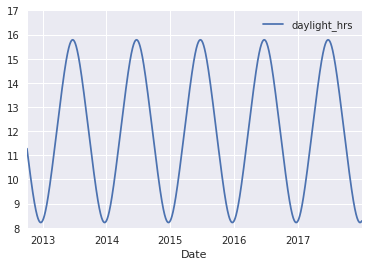

In [21]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [22]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int) #1 for dry days

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [23]:
#measure the time passed in years
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [24]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [25]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

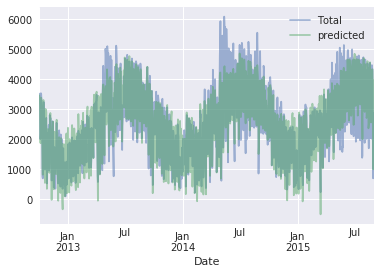

In [26]:
daily[['Total', 'predicted']].plot(alpha=0.5);

We can see that the predicted values match up pretty well but do much worse in the summer, which means either our features are not complete (people decide whether to ride based on more than just this info) or there are nonlinear relationships that we failed to account for(maybe people ride less at *both* high and low temps).

In [27]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

In [30]:
from sklearn.utils import resample #bootstrap resample of data
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [32]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP          -665.0   62.0
dry day        548.0   33.0
Temp (C)        65.0    4.0
annual          27.0   18.0


Features we are probably missing;

+ nonlinear effects (such as effects of precipitation and cold temperature)

+ nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures)

+ the difference between a rainy morning and a rainy afternoon

+ correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days)